In [1]:
import os
import re
from collections import defaultdict

In [2]:
import pandas as pd

data = defaultdict(lambda: {'topic': '', 'content': '', 'messages': [], 'month': ''})

for file_path in os.listdir("cleaned_intercom_messages"):
    csv = pd.read_csv(f"cleaned_intercom_messages/{file_path}")
    csv = csv[csv['clean_body'].notna()]
    bodies = csv["clean_body"]
    ids = zip(csv["key_intercomconversation"], csv["key_iteration"])
    for id, body in zip(ids, bodies):
        m = re.search(" Selected category: (.+) Content: (.+) uid:", body)
        if m is not None:
            data[id]['topic'] = m.group(1)
            data[id]['content'] = m.group(2)
        else:
            data[id]['messages'].append(body)
            if data[id]['month'] == '':
                data[id]['month'] = file_path.split("-")[1]

df = pd.DataFrame.from_dict(data, orient="index")
print(len(df[df["topic"] == '']))
print(len(df[df["topic"] != '']))

329564
10


In [4]:
df.head()

topic content  \
13672140114 5                 
            6                 
            8                 
13675529033 1                 
13675881994 3                 

                                                        messages month  
13672140114 5  [{{name}} im also talking ot this guy, lll, je...    01  
            6                                               [Hm]    01  
            8  [🔗 Riley Young linked SE-{{number}} Blank emai...    04  
13675529033 1  [Guys, please help the customer when he comes ...    03  
13675881994 3                                   [Record a video]    10

In [5]:
new_ids = ["_".join([str(tup[0]), str(tup[1])]) for tup in df.index]

In [6]:
df.index = new_ids

In [7]:
df.head()

,topic,content,messages,month
13672140114_5,,,"[{{name}} im also talking ot this guy, lll, je...",01
13672140114_6,,,[Hm],01
13672140114_8,,,[🔗 Riley Young linked SE-{{number}} Blank emai...,04
13675529033_1,,,"[Guys, please help the customer when he comes ...",03
13675881994_3,,,[Record a video],10


In [8]:
def get_monthly_data(original_data: pd.DataFrame, preprocessed_data: dict, month: str) -> dict:
    ids = original_data[original_data['month'] == month].index
    monthly_data = {}
    for _id in ids:
        if _id in preprocessed_data.keys():
            monthly_data[_id] = preprocessed_data[_id]
        
    return monthly_data

In [9]:
import json

In [13]:
with open("english_texts_by_id.json") as f:
    preprocessed = json.loads(f.read())

In [17]:
len(preprocessed)

246729

In [18]:
months = []

for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']:
    months.append(get_monthly_data(df, preprocessed, month))

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [31]:
import time
from datetime import timedelta

In [34]:
models = []

print("Start:", str(timedelta(seconds=time.time()+7200)).split(", ")[1])

for i, month in enumerate(months):
    lists = month.values()
    X = TfidfVectorizer().fit_transform(lists)
    lda = LatentDirichletAllocation(n_components=7)
    lda.fit(X)
    models.append(lda)
    print(f"Month {i} done at:", str(timedelta(seconds=time.time()+7200)).split(", ")[1])

Start: 17:18:10.114055
Month 0 done at: 17:19:07.649043
Month 1 done at: 17:20:01.630048
Month 2 done at: 17:21:06.425042
Month 3 done at: 17:22:40.977044
Month 4 done at: 17:23:40.074048
Month 5 done at: 17:24:55.096042
Month 6 done at: 17:26:27.096044
Month 7 done at: 17:27:56.797044
Month 8 done at: 17:28:56.888044
Month 9 done at: 17:30:01.568085


In [96]:
lists = months[2].values()
X = TfidfVectorizer().fit_transform(lists)
probs = models[2].transform(X)

In [47]:
import numpy as np

In [97]:
list(lists)[0]

'guys customer come back'

In [98]:
topics_2 = {}

for i in range(7):
    topics_2[i] = []

vals = list(lists)
    
for i, prob in enumerate(probs):
    index = np.argmax(prob)
    topics_2[index].append(vals[i])

In [99]:
for k, v in topics_2.items():
    print(k, len(v))

0 1187
1 34
2 29
3 19921
4 382
5 16
6 2189


In [100]:
topics_2[5]

['tsau oled saadaval hei hei olin lahkumas aga saan proovida veel aidata ka saan kuidagi suurema koguse organisatsioone tehingute alla liigutada kas tähendab korraga tuleks eksisteerivatele organisatsioonidele lisada tehing jes bos selge ja tehingud peak kõik tekkima ühte ja samasse müügitoru staadiumisse korraga saab luua palju tehinguid impordi teel praegusel juhul sorteeriksin organisatsioonid välja millele tarvis tehing luua neil midagi ühist mida saaks filtreerimiseks kasutada teeks listi vaates nende id välja nähtavaks ja ekspordiks excelisse okei selge pilt excelis saaksid lisada veeru kus täpsustad millisesse staadiumisse tehingud peaksid lisanduma samuti saad täpsustada kes peak olema tehingu omanik kui peak olema keegi teine peale sinu mhm tänks nii siin väike video ka näitamaks kuidas korraga mitmetele organisatsioonidele diilid lõin pole kõige sujuvam video tegin pisut kiiruga ja pidin tükk aega otsima kus müügitoru etapi väli harjunud kasutama inglise keelset versiooni aga

In [90]:
model = LatentDirichletAllocation(n_components=25)
X_new = TfidfVectorizer().fit_transform(topics_0[6])
model.fit(X_new)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=25, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [91]:
probabilities = model.transform(X_new)

In [92]:
topics_0_new = {}

for i in range(25):
    topics_0_new[i] = []

vals = list(topics_0[6])
    
for i, prob in enumerate(probabilities):
    index = np.argmax(prob)
    topics_0_new[index].append(vals[i])

In [93]:
for k, v in topics_0_new.items():
    print(k, len(v))

0 12
1 1
2 18025
3 5
4 114
5 5
6 1535
7 1830
8 10
9 6
10 4
11 3
12 74
13 144
14 13
15 227
16 6
17 7
18 6
19 61
20 1694
21 5
22 5
23 14
24 13


In [94]:
topics_0_new[0]

['find deleted deal anywhere permanently deleted hope hear met vriendelijke groet t. .nl werkdagen maandag dinsdag woensdag en donderdag www.rebellease.nl long lease bij daag ons gerust uit hope lovely weekend deleted deal show apply filter much total number deal removed deleted today met vriendelijke groet t. .nl werkdagen maandag dinsdag woensdag en donderdag www.rebellease.nl long lease bij daag ons gerust uit getting back try add deleting deal last update work warm regard lia checking suggestion gave yesterday worked warm regard lia thanks found deleted item step edit filter met vriendelijke groet t. .nl werkdagen maandag dinsdag woensdag en donderdag www.rebellease.nl long lease bij daag ons gerust uit van lia getting back try add deleting deal last update work lia much total number deal removed deleted today met vriendelijke groet t. .nl werkdagen maandag dinsdag woensdag en donderdag www.rebellease.nl long lease bij daag ons gerust uit ~wrd.jpg image.png image.jpg image.jpg imag

In [82]:
topics_0[6][0]

'cancel plan typically reply minute hi reaching sad hear decision leave checked company green shoot capital confirm subscription cancelled expire jan last billing cycle invoice issued subscription suggest exporting data jan date access account restricted reopen account future simply import data back hope free back glad year amir'

In [110]:
from collections import defaultdict

counter = defaultdict(lambda: defaultdict(int))
n = X.shape[0]
transformed = models[2].transform(X[:n])
for i in range(n):
    counted_words = defaultdict(int)
    text = list(months[2].values())[i]
    topic = transformed[i].argmax()
    for word in text.split():
        counter[topic][word] += 1

dict2 = dict()

for topic in counter:
    for word in counter[topic]:
        all_contain = True
        for t in counter:
            all_contain = all_contain and word in counter[t]
        
                
    items = list(counter[topic].items())
    items.sort(key=lambda x: x[1], reverse=True)
    dict2[topic] = items[0:1000]
    
dict2

{6: [('account', 7553),
  ('billing', 5012),
  ('month', 3303),
  ('subscription', 3224),
  ('discount', 2830),
  ('refund', 2738),
  ('back', 2424),
  ('user', 2371),
  ('support', 2212),
  ('escalation', 2192),
  ('cancel', 2039),
  ('time', 2010),
  ('invoice', 1956),
  ('company', 1894),
  ('data', 1826),
  ('able', 1824),
  ('case', 1745),
  ('business', 1695),
  ('hope', 1684),
  ('keep', 1623),
  ('new', 1564),
  ('customer', 1547),
  ('team', 1506),
  ('email', 1502),
  ('situation', 1456),
  ('end', 1416),
  ('payment', 1400),
  ('check', 1390),
  ('next', 1379),
  ('free', 1314),
  ('offer', 1285),
  ('reply', 1258),
  ('reaching', 1253),
  ('best', 1196),
  ('request', 1195),
  ('understand', 1184),
  ('message', 1118),
  ('credit', 1118),
  ('seat', 1103),
  ('id', 1097),
  ('access', 1053),
  ('conversation', 1039),
  ('following', 990),
  ('number', 934),
  ('unfortunately', 914),
  ('make', 913),
  ('monthly', 907),
  ('plan', 893),
  ('much', 887),
  ('current', 878),
 

In [112]:
for k, v in dict2.items():
    for word in v:
        if 'corona' in word[0] or 'covid' in word[0]:
            print(k, word)

6 ('covid-', 390)
6 ('covid', 269)
6 ('corona', 257)
6 ('coronavirus', 71)
5 ('corona', 2)


---

### OTSIME KOROONAT

In [113]:
corona = {}

for i in range(10):
    corona[i] = []

In [116]:
for i in range(10):
    lists = months[i].values()
    X = TfidfVectorizer().fit_transform(lists)
    probs = models[i].transform(X)
    
    topics = {}

    for idx in range(7):
        topics[idx] = []

    vals = list(lists)

    for idx, prob in enumerate(probs):
        index = np.argmax(prob)
        topics[index].append(vals[idx])
        
        
    counter = defaultdict(lambda: defaultdict(int))
    n = X.shape[0]
    transformed = models[i].transform(X[:n])
    for idx in range(n):
        counted_words = defaultdict(int)
        text = list(months[i].values())[idx]
        topic = transformed[idx].argmax()
        for word in text.split():
            counter[topic][word] += 1

    dict2 = dict()

    for topic in counter:
        for word in counter[topic]:
            all_contain = True
            for t in counter:
                all_contain = all_contain and word in counter[t]


        items = list(counter[topic].items())
        items.sort(key=lambda x: x[1], reverse=True)
        dict2[topic] = items[0:2000]
        
    for k, v in dict2.items():
        for word in v:
            if 'corona' in word[0] or 'covid' in word[0]:
                corona[i].append([k, word])

In [117]:
corona

{0: [],
 1: [],
 2: [[6, ('covid-', 390)],
  [6, ('covid', 269)],
  [6, ('corona', 257)],
  [6, ('coronavirus', 71)],
  [3, ('covid-', 158)],
  [3, ('corona', 122)],
  [0, ('covid-', 33)],
  [0, ('covid', 27)],
  [0, ('corona', 20)],
  [5, ('corona', 2)]],
 3: [[2, ('covid', 680)],
  [2, ('covid-', 679)],
  [2, ('1covid-discount', 384)],
  [2, ('corona', 273)],
  [2, ('coronavirus', 90)],
  [1, ('covid', 51)],
  [1, ('covid-', 36)],
  [6, ('covid', 13)],
  [6, ('coronavirus', 7)],
  [6, ('corona', 4)]],
 4: [[2, ('covid', 332)],
  [2, ('covid-', 266)],
  [2, ('1covid-discount', 216)],
  [3, ('covid', 42)],
  [3, ('covid-', 26)],
  [5, ('covid', 61)],
  [5, ('covid-', 57)],
  [5, ('1covid-discount', 26)],
  [5, ('corona', 24)],
  [5, ('coronavirus', 12)],
  [6, ('1covid-discount', 41)],
  [6, ('corona', 40)],
  [6, ('covid', 3)],
  [6, ('covid-', 2)],
  [1, ('covid-', 2)]],
 5: [[0, ('covid', 258)],
  [0, ('1covid-discount', 170)],
  [0, ('covid-', 162)],
  [6, ('covid', 22)],
  [5, ('1

In [118]:
corona_counts = {}

for i in range(10):
    corona_counts[i] = {}
    for topic in corona[i]:
        topic_nr = topic[0]
        c = topic[1]
        if topic_nr in corona_counts[i].keys():
            corona_counts[i][topic_nr] += c[1]
        else:
            corona_counts[i][topic_nr] = c[1]

In [119]:
corona_counts

{0: {},
 1: {},
 2: {6: 987, 3: 280, 0: 80, 5: 2},
 3: {2: 2106, 1: 87, 6: 24},
 4: {2: 814, 3: 68, 5: 180, 6: 86, 1: 2},
 5: {0: 590, 6: 22, 5: 50},
 6: {3: 411, 6: 4},
 7: {1: 208, 2: 14, 6: 1},
 8: {1: 3},
 9: {2: 15}}

In [120]:
from matplotlib import pyplot as plt

In [135]:
df = pd.DataFrame.from_dict(corona_counts).fillna(0)

In [136]:
df = df.astype(int)
df

,0,1,2,3,4,5,6,7,8,9
0,0,0,80,0,0,590,0,0,0,0
1,0,0,0,87,2,0,0,208,3,0
2,0,0,0,2106,814,0,0,14,0,15
3,0,0,280,0,68,0,411,0,0,0
5,0,0,2,0,180,50,0,0,0,0
6,0,0,987,24,86,22,4,1,0,0


In [139]:
import seaborn as sns

In [145]:
["y"]*3+["z"]*3

['y', 'y', 'y', 'z', 'z', 'z']

In [152]:
df.loc[5]

0      0
1      0
2      2
3      0
4    180
5     50
6      0
7      0
8      0
9      0
Name: 5, dtype: int32

In [171]:
list(df[0])+list(df[1])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

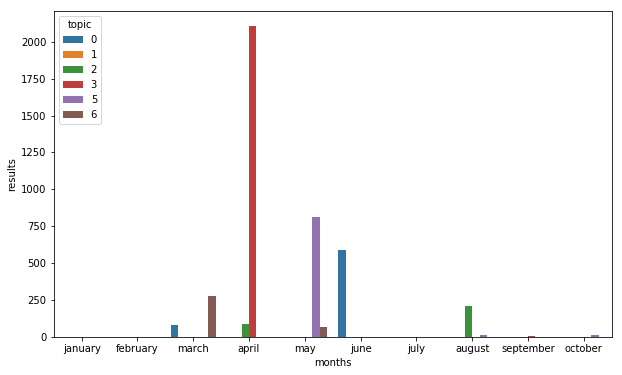

In [162]:
data = pd.DataFrame(zip(["january", "february", "march", "april", "may", "june", "july", "august", "september", "october"]*6, ["0"]*6+["1"]*6+["2"]*6+["3"]*6+["5"]*6+["6"]*6, list(df.loc[0])+list(df.loc[1])+list(df.loc[2])+list(df.loc[3])+list(df.loc[5])+list(df.loc[6])), columns=["months", "topic", "results"])
plt.figure(figsize=(10, 6))
sns.barplot(x="months", y="results", hue="topic", data=data)

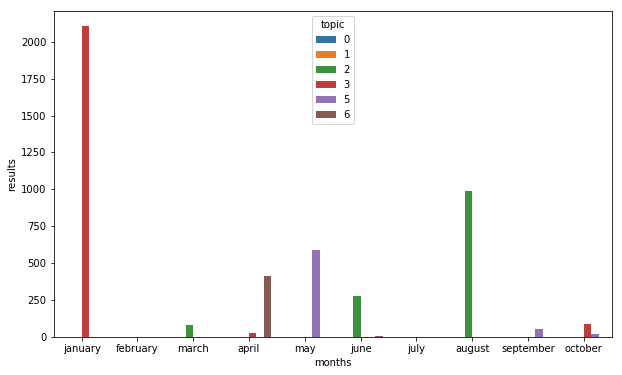

In [172]:
data = pd.DataFrame(zip(["january", "february", "march", "april", "may", "june", "july", "august", "september", "october"]*6, ["0"]*6+["1"]*6+["2"]*6+["3"]*6+["5"]*6+["6"]*6, list(df[0])+list(df[1])+list(df[2])+list(df[3])+list(df[5])+list(df[6])+list(df[7])+list(df[8])+list(df[9])), columns=["months", "topic", "results"])
plt.figure(figsize=(10, 6))
sns.barplot(x="months", y="results", hue="topic", data=data)

In [177]:
df.loc[3]

0      0
1      0
2    280
3      0
4     68
5      0
6    411
7      0
8      0
9      0
Name: 3, dtype: int32

In [185]:
df2 = df.drop(3, axis=1)
df2

,0,1,2,4,5,6,7,8,9
0,0,0,80,0,590,0,0,0,0
1,0,0,0,2,0,0,208,3,0
2,0,0,0,814,0,0,14,0,15
3,0,0,280,68,0,411,0,0,0
5,0,0,2,180,50,0,0,0,0
6,0,0,987,86,22,4,1,0,0


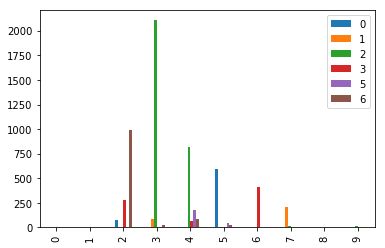

In [194]:
df.T.plot(kind='bar')

<BarContainer object of 6 artists>

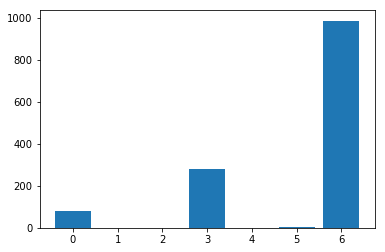

In [195]:
plt.bar(df.index, df[2])

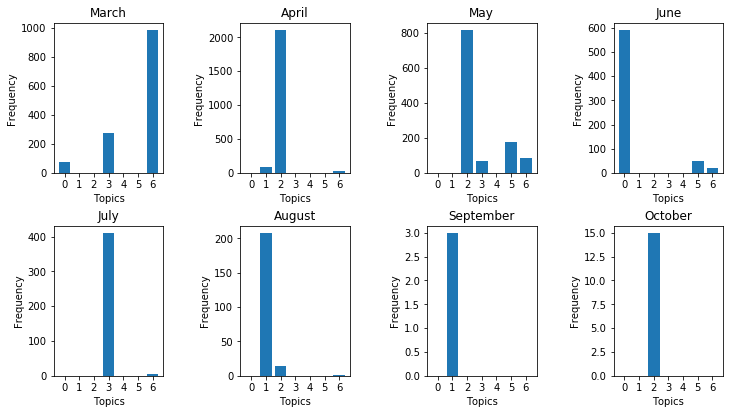

In [229]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.35, wspace=0.7)

current = 2
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
        
for row in ax:
    for col in row:
        col.bar(df.index, df[current])
        col.set_xticks(range(7))
        col.set_xlabel("Topics")
        col.set_ylabel("Frequency")
        col.title.set_text(months[current])
        current += 1

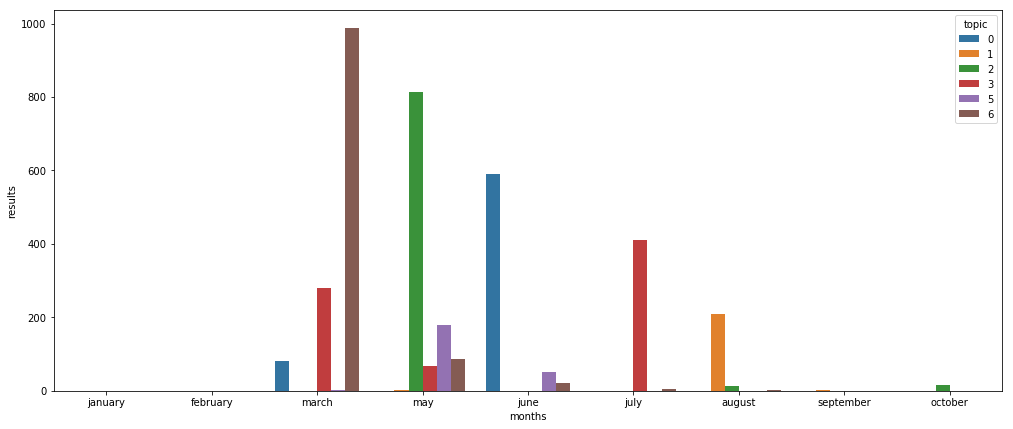

In [186]:
data = pd.DataFrame(zip(["january", "february", "march", "may", "june", "july", "august", "september", "october"]*9, ["0"]*9+["1"]*9+["2"]*9+["3"]*9+["5"]*9+["6"]*9, list(df2.loc[0])+list(df2.loc[1])+list(df2.loc[2])+list(df2.loc[3])+list(df2.loc[5])+list(df2.loc[6])), columns=["months", "topic", "results"])
plt.figure(figsize=(17, 7))
sns.barplot(x="months", y="results", hue="topic", data=data)

In [184]:
data

,months,topic,results
0,january,0,0
1,february,0,0
2,march,0,80
3,may,0,0
4,june,0,0
5,july,0,590
6,august,0,0
7,september,0,0
8,october,0,0
9,january,1,0


---

In [95]:
from collections import defaultdict

counter = defaultdict(lambda: defaultdict(int))
n = X_new.shape[0]
transformed = model.transform(X_new[:n])
for i in range(n):
    counted_words = defaultdict(int)
    text = topics_0[6][i]
    topic = transformed[i].argmax()
    for word in text.split():
        counter[topic][word] += 1

dict2 = dict()

for topic in counter:
    for word in counter[topic]:
        all_contain = True
        for t in counter:
            all_contain = all_contain and word in counter[t]
        
                
    items = list(counter[topic].items())
    items.sort(key=lambda x: x[1], reverse=True)
    dict2[topic] = items[0:10]
    
dict2

{6: [('account', 4810),
  ('billing', 3833),
  ('subscription', 1870),
  ('user', 1848),
  ('refund', 1582),
  ('invoice', 1577),
  ('new', 1505),
  ('support', 1443),
  ('email', 1347),
  ('company', 1242)],
 2: [('email', 49331),
  ('deal', 36525),
  ('support', 25054),
  ('user', 22669),
  ('contact', 22545),
  ('account', 20953),
  ('new', 20601),
  ('issue', 17613),
  ('free', 17550),
  ('time', 16994)],
 7: [('email', 2084),
  ('account', 1747),
  ('support', 1348),
  ('new', 1114),
  ('free', 1105),
  ('issue', 1070),
  ('user', 1011),
  ('case', 990),
  ('back', 988),
  ('message', 978)],
 13: [('support', 170),
  ('new', 169),
  ('back', 137),
  ('require', 136),
  ('free', 126),
  ('reply', 118),
  ('conversation', 109),
  ('open', 107),
  ('another', 103),
  ('touch', 102)],
 15: [('email', 3644),
  ('sync', 741),
  ('support', 476),
  ('deal', 449),
  ('link', 413),
  ('issue', 409),
  ('address', 383),
  ('feature', 380),
  ('contact', 342),
  ('tracking', 338)],
 8: [('ac

In [86]:
counter.keys()

dict_keys([1, 4, 6, 3, 0, 2, 5])